In [1]:
import numpy as np
from mvlearn.embed import GCCA
from mvlearn.datasets import sample_joint_factor_model
from graspy.plot import pairplot
from scipy.sparse.linalg import svds
from pathlib import Path
from hyppo.independence import Dcorr

import sys; sys.path.append('../')
from src.tools import iterate_align, align
from src.sims import two_samp_bases, ortho_bases
from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

In [2]:
def plot_alignments(objs, objs_normal, max_iter):
    
    objs_means = np.mean(objs, axis=0)
    objs_std = np.std(objs, axis=0)
    objs_normal_means = np.mean(objs_normal, axis=0)
    objs_normal_std = np.std(objs_normal, axis=0)

    colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
    f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
    iters = np.arange(objs_means.shape[0])

    ax = axs[0]
    for i in range(objs_means.shape[1]):
        y = objs_normal_means[:, i]
        yerr = objs_normal_std[:, i]
        if i % 2 == 0:
            ls = '-'
        else:
            ls = '--'
        ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
        # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

    ax.set_title('normal procrustes')
    ax.set_xlabel('iteration')
    ax.set_ylabel('l2 norm o diff w/ mean')
    # ax.set_ylim(0,1)

    iters = np.arange(max_iter)
    ax = axs[1]
    for i in range(objs_means.shape[1]):
        y = objs_means[max_iter:, i]
        yerr = objs_std[max_iter:, i]
        if i % 2 == 0:
            ls = '-'
        else:
            ls = '--'
        ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
    ax.set_title('mean procrustes')
    # ax.set_ylim(0,1)

    ax = axs[2]
    diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
    iters = np.arange(max_iter)
    for i in range(objs_means.shape[1]):
        y = np.mean(diff[:,:,i], axis=0)
        yerr = np.std(diff[:,:,i], axis=0)
        if i % 2 == 0:
            ls = '-'
        else:
            ls = '--'
        ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
    ax.axhline(0, ls='--', c='black')

    ax.set_title('normal - multilevel')
    ax.set_xlabel('iteration')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle('shared and orthogonal bases: unidentifiable')
    plt.show()

############### Heatmap ###############
def plot_heatmap(trace_normal, trace_mats):
    trace_means = np.mean(trace_mats, axis=0)
    trace_std = np.std(trace_mats, axis=0)
    trace_normal_means = np.mean(trace_normal, axis=0)
    trace_normal_std = np.std(trace_normal, axis=0)
    n_grads = len(trace_normal_means)
    fig, axs = plt.subplots(n_grads, 3, figsize=(16,3*n_grads))
    for g in range(n_grads):
        mat = trace_normal_means[g,:,:]
        ax = axs[g, 0]
        ax = sns.heatmap(
            mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
        if g == 0:
            ax.set_title('procrustes mean')
        ax.set_yticklabels([])
        if g == n_grads-1:
            ax.set_xticks(np.arange(len(labels)))
            ax.set_xticklabels(labels, rotation=-30, ha='left')
        else:
            ax.set_xticklabels([])
        ax.set_ylabel(f'Gradient {g}')

        ax = axs[g, 1]
        mat = trace_means[g,:,:]
        ax = sns.heatmap(
            mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
        if g == 0:
            ax.set_title('multilevel-procrustes mean')
        ax.set_yticklabels([])
        if g == n_grads-1:
            ax.set_xticks(np.arange(len(labels)))
            ax.set_xticklabels(labels, rotation=-30, ha='left')
        else:
            ax.set_xticklabels([])

        ax = axs[g, 2]
        mat = trace_normal_means - trace_means
        mat = mat[g,:,:]
        ax = sns.heatmap(
            mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
        if g == 0:
            ax.set_title('normal - multiway')
        ax.set_yticklabels([])
        if g == n_grads-1:
            ax.set_xticks(np.arange(len(labels)))
            ax.set_xticklabels(labels, rotation=-30, ha='left')
        else:
            ax.set_xticklabels([])

    fig.tight_layout()
    plt.show()
    
def plot_pvals(pvals, name='Procrustes'):
    m = pvals.shape[1]
    f, axs = plt.subplots(1,m,sharey=True,sharex=True, figsize=(12,2))
    r = 1
    for c in range(m):
        test = pvals[:, c]
        ax = axs[c]
        n = len(test)
        entries, edges, _ = ax.hist(test, bins = np.arange(0,1.1,0.05), weights=np.ones(n)/n, color='b')
        # entries = height of each column = proportion in that bin
        # calculate bin centers
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
        # errorbars are binomial proportion confidence intervals
        ax.errorbar(
            bin_centers, entries,
            yerr = 1.96 * np.sqrt(entries * (1 - entries) / n),
            fmt='.',c='#333333'
        )
        ax.set_title(f'{name}, {c+1}')
        #ax.set_xlim(0,1)
        if r == 0:
            ax.set_xticks([])
        else:
            ax.set_xticks([0,1])
        if c == 0:
            ax.set_xticks([0, 0.1, 1])
        else:
            ax.set_xticks([0,1])
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

In [192]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 100
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)
p = np.exp(-np.arange(d))
p *= 1 / p[-1] / n
p /= np.sum(p)

for _ in range(reps):
    shared_bases = sorted([np.random.choice(d, p=p) for _ in range(n_subjs)])
    indiv_bases = [0] + [np.random.randint(d-shared_bases[i], int(n / n_subjs)) for i in range(n_subjs)]
    indiv_bases = np.cumsum(indiv_bases) + d
    indiv_idx = [np.arange(indiv_bases[i], indiv_bases[i+1]) for i in range(n_subjs)]
    Xs = np.vstack([[
        ortho_group.rvs(n)[:,np.hstack((np.arange(shared_bases[i]), indiv_idx[i]))] @
        ortho_group.rvs(shared_bases[i] + len(indiv_idx[i]))[:,:d]
        for _ in range(2)] for i in range(n_subjs)])
    subjs = np.hstack([[i]*2 for i in range(n_subjs)])
    labels = np.hstack([np.zeros(n_subjs), np.ones(n_subjs)])
    
#     Xs, labels, subjs = two_samp_bases(
#         n_subjs=n_subjs, n=n, d_shared=2, d_indiv=2, n_shared_bases=3, n_indiv_bases=3, epsilon=0, per_subj=2)
    
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
        tmp.append(pvalue)
    pvals.append(tmp)
    
    trace_mat = [[
        [np.linalg.norm(embs[i, :, g] - embs[j, :, g]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ] for g in range(embs.shape[2])]
    trace_normal.append(np.asarray(trace_mat))
    embs_normal = embs
        
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=True, debug=True
    )
    objs.append(obs)
    embs = np.asarray(embs)
#     tmp = []
#     for i in range(embs.shape[-1]):
#         stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
#         tmp.append(pvalue)
#     pvals_normal.append(tmp)
    trace_mat = [[
        [np.linalg.norm(embs[i, :, g] - embs[j, :, g]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ] for g in range(embs.shape[2])]
    trace_mats.append(np.asarray(trace_mat))
pvals = np.asarray(pvals)
# pvals_normal = np.asarray(pvals_normal)

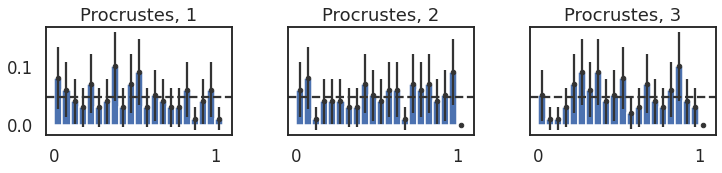

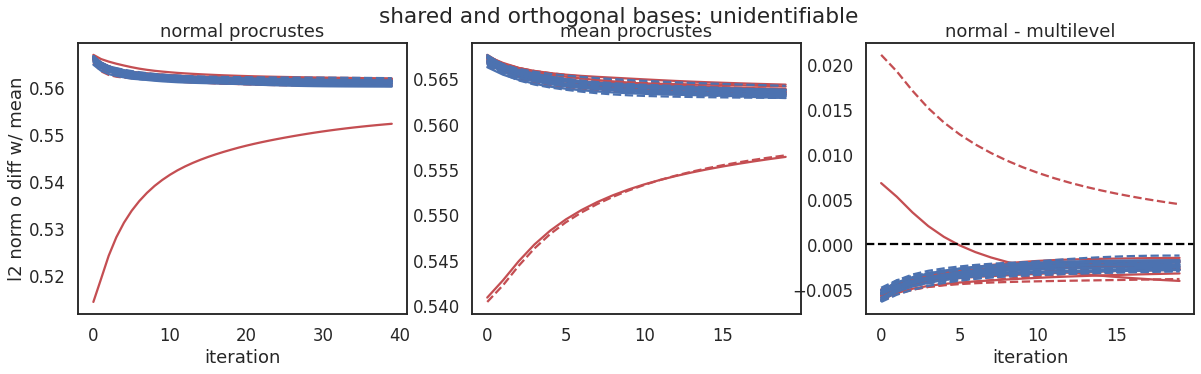

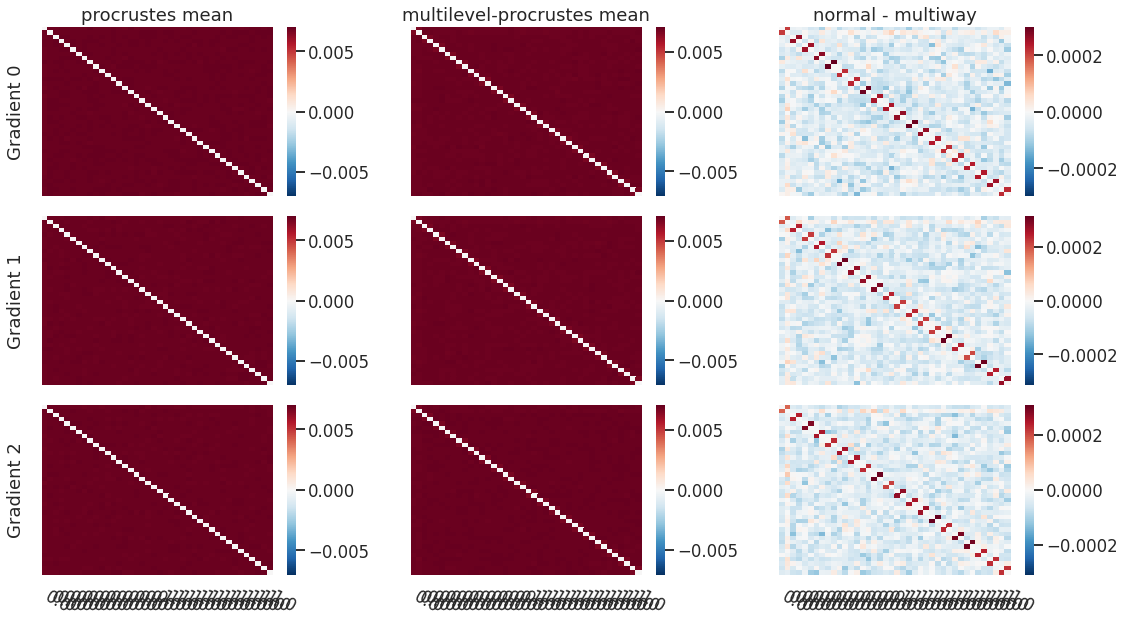

In [193]:
plot_pvals(pvals)
plot_alignments(objs, objs_normal, max_iter)
plot_heatmap(trace_normal, trace_mats)

In [182]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 20
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)

pvals = []
Xs, labels, subjs = two_samp_bases(
        n_subjs=n_subjs, n=n, d_shared=2, d_indiv=1, n_shared_bases=3, n_indiv_bases=2, epsilon=0, per_subj=2)

for s in range(2*n_subjs):
    start = 2*s
    Xs2 = np.concatenate((Xs[start:], Xs[:start]))
    labels2 = np.concatenate((labels[start:], labels[:start]))
    subjs2 = np.concatenate((subjs[start:], subjs[:start]))
    obs, embs, _, _ = iterate_align(
        Xs2, labels2, subjs2, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
        tmp.append(pvalue)
    pvals.append(tmp)
pvals = np.asarray(pvals)

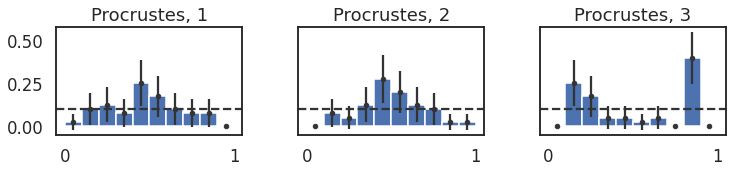

Grad 0: mean=0.46, std=0.212
Grad 1: mean=0.50, std=0.178
Grad 2: mean=0.49, std=0.306


In [183]:
plot_pvals(pvals)
for i in range(pvals.shape[1]):
    print(f'Grad {i}: mean={np.mean(pvals[:,i]):.2f}, std={np.std(pvals[:,i]):.3f}')

In [184]:
pvals_2samp = pvals

In [171]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 20
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)

Xs, labels, subjs = two_samp_bases(
        n_subjs=n_subjs, n=n, d_shared=2, d_indiv=1, n_shared_bases=3, n_indiv_bases=2, epsilon=0, per_subj=2)
pvals = []
for s in range(2*n_subjs):
    start = 2*s
    start = 0
    Xs2 = np.concatenate((Xs[start:], Xs[:start]))
    labels2 = np.concatenate((labels[start:], labels[:start]))
    subjs2 = np.concatenate((subjs[start:], subjs[:start]))
    obs, embs, _, _ = iterate_align(
        Xs2, labels2, subjs2, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
        tmp.append(pvalue)
    pvals.append(tmp)
pvals = np.asarray(pvals)

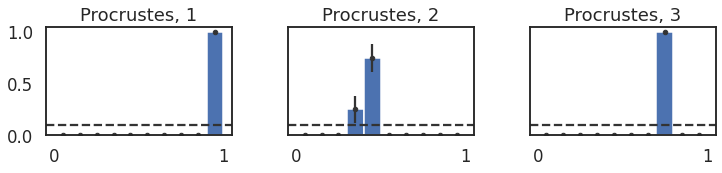

In [172]:
plot_pvals(pvals)

In [181]:
for i in range(pvals.shape[1]):
    print(f'Grad {i}: mean={np.mean(pvals[:,i]):.2f}, std={np.std(pvals[:,i]):.3f}')

Grad 0: mean=0.98, std=0.004
Grad 1: mean=0.41, std=0.017
Grad 2: mean=0.76, std=0.013


In [194]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 20
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)
p = np.exp(-np.arange(d))
p *= 1 / p[-1] / n
p /= np.sum(p)

shared_bases = sorted([np.random.choice(d, p=p) for _ in range(n_subjs)])[::-1]
indiv_bases = [0] + [np.random.randint(d-shared_bases[i], int(n / n_subjs)) for i in range(n_subjs)]
indiv_bases = np.cumsum(indiv_bases) + d
indiv_idx = [np.arange(indiv_bases[i], indiv_bases[i+1]) for i in range(n_subjs)]
Xs = np.vstack([[
    ortho_group.rvs(n)[:,np.hstack((np.arange(shared_bases[i]), indiv_idx[i]))] @
    ortho_group.rvs(shared_bases[i] + len(indiv_idx[i]))[:,:d]
    for _ in range(2)] for i in range(n_subjs)])
subjs = np.hstack([[i]*2 for i in range(n_subjs)])
labels = np.hstack([np.zeros(n_subjs), np.ones(n_subjs)])

pvals = []
for s in range(n_subjs):
    start = 2*s
    Xs2 = np.concatenate((Xs[start:], Xs[:start]))
    labels2 = np.concatenate((labels[start:], labels[:start]))
    subjs2 = np.concatenate((subjs[start:], subjs[:start]))
    obs, embs, _, _ = iterate_align(
        Xs2, labels2, subjs2, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
        tmp.append(pvalue)
    pvals.append(tmp)
pvals = np.asarray(pvals)

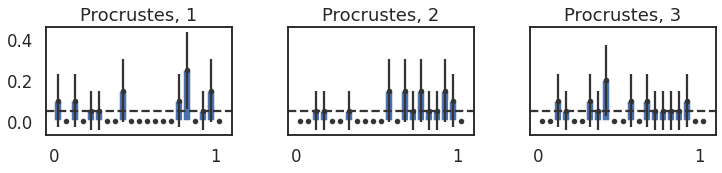

Grad 0: mean=0.58, std=0.335
Grad 1: mean=0.70, std=0.241
Grad 2: mean=0.53, std=0.251


In [195]:
plot_pvals(pvals)
for i in range(pvals.shape[1]):
    print(f'Grad {i}: mean={np.mean(pvals[:,i]):.2f}, std={np.std(pvals[:,i]):.3f}')

In [ ]:
pvals_extreme = pvals

In [197]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 4
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)

rep_pvals = []
for _ in range(reps):
    pvals = []
    Xs, labels, subjs = two_samp_bases(
            n_subjs=n_subjs, n=n, d_shared=2, d_indiv=1, n_shared_bases=3, n_indiv_bases=2, epsilon=0, per_subj=2)

    for s in range(2*n_subjs):
        start = 2*s
        Xs2 = np.concatenate((Xs[start:], Xs[:start]))
        labels2 = np.concatenate((labels[start:], labels[:start]))
        subjs2 = np.concatenate((subjs[start:], subjs[:start]))
        obs, embs, _, _ = iterate_align(
            Xs2, labels2, subjs2, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
        )
        objs_normal.append(obs)
        embs = np.asarray(embs)
        tmp = []
        for i in range(embs.shape[-1]):
            stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
            tmp.append(pvalue)
        pvals.append(tmp)
    rep_pvals.append(pvals)
rep_pvals = np.asarray(rep_pvals)

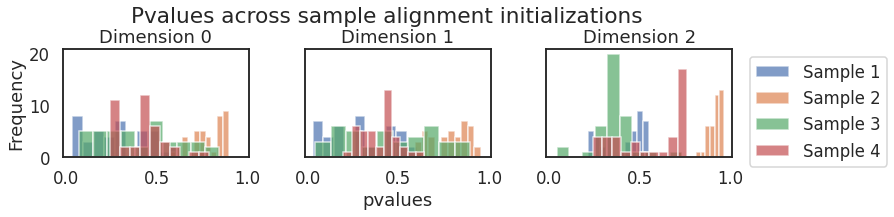

In [217]:
m = rep_pvals.shape[-1]
f, axs = plt.subplots(1,m,sharey=True,sharex=True, figsize=(12,2))
r = 1
for c in range(m):
    ax = axs[c]
    for samp in range(rep_pvals.shape[0]):
        ax.hist(rep_pvals[samp, :, c], label=f'Sample {samp+1}', alpha=0.7)
    ax.set_title(f'Dimension {c}')
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Pvalues across sample alignment initializations', y=1.17)

axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('pvalues')
plt.show()

In [3]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 1

reps = 4
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)

rep_pvals_1 = []
for _ in range(reps):
    pvals = []
    Xs, labels, subjs = two_samp_bases(
            n_subjs=n_subjs, n=n, d_shared=2, d_indiv=1, n_shared_bases=3, n_indiv_bases=2, epsilon=0, per_subj=2)

    for s in range(2*n_subjs):
        start = 2*s
        Xs2 = np.concatenate((Xs[start:], Xs[:start]))
        labels2 = np.concatenate((labels[start:], labels[:start]))
        subjs2 = np.concatenate((subjs[start:], subjs[:start]))
        embs, _, _ = iterate_align(
            Xs2, labels2, subjs2, thresh=thresh, max_iter=max_iter, norm=False, mean_align=False, debug=False
        )
        embs = np.asarray(embs)
        tmp = []
        for i in range(embs.shape[-1]):
            stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
            tmp.append(pvalue)
        pvals.append(tmp)
    rep_pvals_1.append(pvals)
rep_pvals_1 = np.asarray(rep_pvals_1)

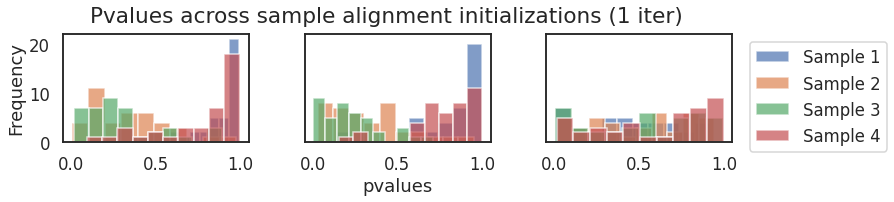

In [6]:
tests = rep_pvals_1
m = tests.shape[-1]
f, axs = plt.subplots(1,m,sharey=True,sharex=True, figsize=(12,2))
r = 1
for c in range(m):
    ax = axs[c]
    for samp in range(tests.shape[0]):
        ax.hist(tests[samp, :, c], label=f'Sample {samp+1}', alpha=0.7)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Pvalues across sample alignment initializations (1 iter)', y=1.07)
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('pvalues')
plt.show()

In [13]:
for i in range(tests.shape[-1]):
    mean_mean = np.mean(np.mean(tests[:,:,i], axis=1))
    std_mean = np.std(np.mean(tests[:,:,i], axis=1))
    std_mean = np.mean(np.std(tests[:,:,i], axis=1))
    std_std = np.std(np.std(tests[:,:,i], axis=1))
    print(f'Samp {samp}, Grad {i}: mean={mean_mean:.2f}+-{std_mean:.2f}, std={std_mean:.3f}+-{std_std:.3f}')

Samp 3, Grad 0: mean=0.57+-0.21, std=0.206+-0.042
Samp 3, Grad 1: mean=0.54+-0.20, std=0.196+-0.017
Samp 3, Grad 2: mean=0.51+-0.30, std=0.304+-0.019


In [213]:
n_subjs = 20
n = 200
d = 3
thresh = 0
max_iter = 5

reps = 4
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []
n_shared_bases = 2
shared_idx = np.arange(n_shared_bases)

rep_pvals_5 = []
for _ in range(reps):
    pvals = []
    Xs, labels, subjs = two_samp_bases(
            n_subjs=n_subjs, n=n, d_shared=2, d_indiv=1, n_shared_bases=3, n_indiv_bases=2, epsilon=0, per_subj=2)

    for s in range(2*n_subjs):
        start = 2*s
        Xs2 = np.concatenate((Xs[start:], Xs[:start]))
        labels2 = np.concatenate((labels[start:], labels[:start]))
        subjs2 = np.concatenate((subjs[start:], subjs[:start]))
        embs, _, _ = iterate_align(
            Xs2, labels2, subjs2, thresh=thresh, max_iter=max_iter, norm=False, mean_align=False
        )
        embs = np.asarray(embs)
        tmp = []
        for i in range(embs.shape[-1]):
            stat, pvalue = Dcorr().test(embs[:, :, i], labels2, perm_blocks=subjs2)
            tmp.append(pvalue)
        pvals.append(tmp)
    rep_pvals_5.append(pvals)
rep_pvals_5 = np.asarray(rep_pvals_5)

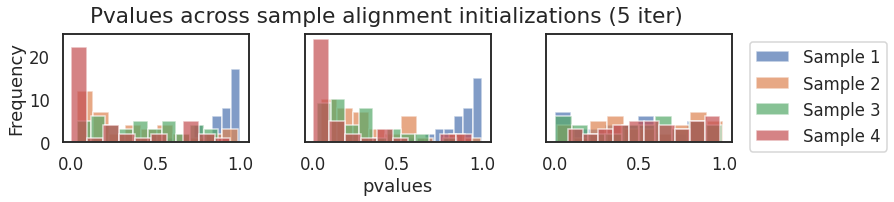

In [214]:
tests = rep_pvals_5
m = tests.shape[-1]
f, axs = plt.subplots(1,m,sharey=True,sharex=True, figsize=(12,2))
r = 1
for c in range(m):
    ax = axs[c]
    for samp in range(tests.shape[0]):
        ax.hist(tests[samp, :, c], label=f'Sample {samp+1}', alpha=0.7)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Pvalues across sample alignment initializations (5 iter)', y=1.07)
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('pvalues')
plt.show()